Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 109s 5s/step - inundado_accuracy: 0.5659 - inundado_loss: 0.9744 - loss: 2.2320 - transitable_accuracy: 0.5121 - transitable_loss: 1.2581 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6900 - val_loss: 1.3816 - val_transitable_accuracy: 0.5714 - val_transitable_loss: 0.6916 - learning_rate: 1.0000e-04
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step - inundado_accuracy: 0.5164 - inundado_loss: 0.8106 - loss: 1.7430 - transitable_accuracy: 0.5075 - transitable_loss: 0.9319 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6912 - val_loss: 1.3820 - val_transitable_accuracy: 0.5714 - val_transitable_loss: 0.6908 - learning_rate: 1.0000e-04
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - inundado_accuracy: 0.4626 - inundado_loss: 0.7115 - loss: 1.4803 - transitable_accuracy: 0.5231 - transitable_loss: 0.7643 - val_inundado_accuracy: 0.5714 - val_inundado_loss: 0.6913 - val_loss: 1.3818 - val_transitable_accuracy: 0.5714 - val_transitable_loss: 0.6

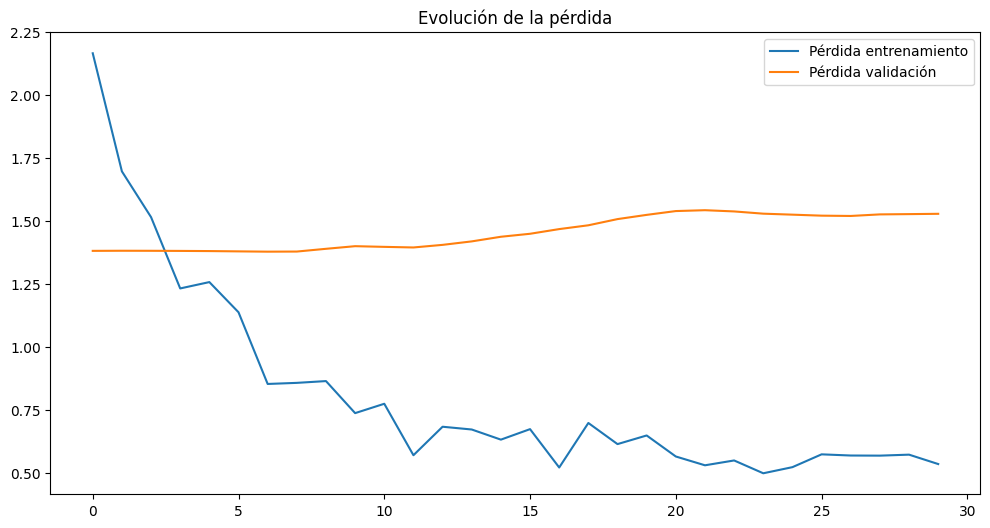

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - inundado_accuracy: 0.4286 - inundado_loss: 0.8397 - loss: 1.5288 - transitable_accuracy: 0.8571 - transitable_loss: 0.6891

=== Resultados en Prueba ===
loss: 1.5288
compile_metrics: 0.6891
transitable_loss: 0.8397
inundado_loss: 0.4286


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from datetime import datetime

## Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Parámetros
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
INIT_LR = 1e-4

## Rutas
TRAIN_CSV = '/kaggle/input/dataset/labels/train_data.csv'
TRAIN_IMG_DIR = '/kaggle/input/dataset/images'
TEST_CSV = '/kaggle/input/test-all/labels/test_data.csv'
TEST_IMG_DIR = '/kaggle/input/test-all/images'

## Carga de datos
train_df = pd.read_csv(TRAIN_CSV)
test_df = pd.read_csv(TEST_CSV)

## Balanceo de datos
class_counts = train_df[['transitable', 'Inundado']].sum()
max_count = class_counts.max()
train_df_balanced = train_df.copy()
for col in ['transitable', 'Inundado']:
    samples_to_add = max_count - class_counts[col]
    if samples_to_add > 0:
        additional_samples = train_df[train_df[col] == 1].sample(samples_to_add, replace=True)
        train_df_balanced = pd.concat([train_df_balanced, additional_samples])

## Generador de datos
class MultiTargetGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, img_dir, batch_size=32, shuffle=True, augment=False):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.on_epoch_end()
        
        self.augmenter = ImageDataGenerator(
            rotation_range=30,
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            zoom_range=0.3,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    
    def __len__(self):
        return int(np.ceil(len(self.df) / self.batch_size))
    
    def __getitem__(self, index):
        start_idx = index * self.batch_size
        end_idx = min((index + 1) * self.batch_size, len(self.df))
        batch_indices = self.indices[start_idx:end_idx]
        
        X = np.empty((len(batch_indices), *IMG_SIZE, 3))
        y_transitable = np.empty((len(batch_indices), 1))
        y_inundado = np.empty((len(batch_indices), 1))
        
        for i, idx in enumerate(batch_indices):
            row = self.df.iloc[idx]
            img_path = os.path.join(self.img_dir, f"{row['ID']}.jpg")
            
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMG_SIZE)
            
            if self.augment:
                img = self.augmenter.random_transform(img)
                
            X[i,] = img / 255.0
            
            y_transitable[i,] = row['transitable']
            y_inundado[i,] = row['Inundado']
            
        return X, {'transitable': y_transitable, 'inundado': y_inundado}
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle:
            np.random.shuffle(self.indices)

## Modelo

def build_multi_target_model():
    base_model = EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=(*IMG_SIZE, 3),
        pooling='avg'
    )
    base_model.trainable = True  # Permitir ajuste fino
    
    inputs = Input(shape=(*IMG_SIZE, 3))
    x = base_model(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    
    transitable_branch = Dense(128, activation='relu')(x)
    transitable_branch = Dropout(0.3)(transitable_branch)
    transitable_output = Dense(1, activation='sigmoid', name='transitable')(transitable_branch)
    
    inundado_branch = Dense(128, activation='relu')(x)
    inundado_branch = Dropout(0.3)(inundado_branch)
    inundado_output = Dense(1, activation='sigmoid', name='inundado')(inundado_branch)
    
    model = Model(inputs=inputs, outputs=[transitable_output, inundado_output])
    
    model.compile(
        optimizer=Adam(learning_rate=INIT_LR),
        loss={'transitable': 'binary_crossentropy', 'inundado': 'binary_crossentropy'},
        metrics={'transitable': ['accuracy'], 'inundado': ['accuracy']}
    )
    
    return model

## Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

## Evaluación del modelo
def evaluate_on_test(model):
    test_gen = MultiTargetGenerator(test_df, TEST_IMG_DIR, augment=False, shuffle=False, batch_size=BATCH_SIZE)
    results = model.evaluate(test_gen, verbose=1)
    
    print("\n=== Resultados en Prueba ===")
    for i, metric in enumerate(model.metrics_names):
        print(f"{metric}: {results[i]:.4f}")

## Visualización de resultados
def plot_results(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Pérdida entrenamiento')
    plt.plot(history.history['val_loss'], label='Pérdida validación')
    plt.legend()
    plt.title('Evolución de la pérdida')
    plt.show()

if __name__ == "__main__":
    model = build_multi_target_model()
    history = model.fit(
        MultiTargetGenerator(train_df_balanced, TRAIN_IMG_DIR, augment=True),
        validation_data=MultiTargetGenerator(test_df, TEST_IMG_DIR),
        epochs=EPOCHS,
        callbacks=[reduce_lr]
    )
    plot_results(history)
    evaluate_on_test(model)
